# Importing Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Import Data

In [2]:
from ham import create_dataset,get_default_dataset,classes

height,width = 32,32 # Only change this line if using a different image size
channel = 3
input_shape = (height, width, channel)
reshape = (-1,height,width,channel)

In [3]:
if height == width == 28:
    # Use default dataset
    data,testset,data_meta,testset_meta = get_default_dataset()
else:
    # Generate the dataset (if using a different shape) - runs for 5 mins
    data,testset,data_meta,testset_meta  = create_dataset(resize=(height, width))


Downloading...
From (uriginal): https://drive.google.com/uc?id=1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG
From (redirected): https://drive.google.com/uc?id=1vNLwZ4ao7eZTAeH0JRIhaZ1QbiP3LsDG&confirm=t&uuid=b6c6cc3d-d026-4398-b85c-d8b63b39afdc
To: c:\Users\maryp\Desktop\skin_cancer_classification\file.zip
100%|██████████| 1.37G/1.37G [37:23<00:00, 609kB/s] 


Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1w6eRHc4sKJ1jzh5gU112HK8mfgraqcIj 

Downloading...
From (uriginal): https://drive.google.com/uc?id=1n71CVP_3-OpcwSaC6z1Y1JCyCznzVP9t
From (redirected): https://drive.google.com/uc?id=1n71CVP_3-OpcwSaC6z1Y1JCyCznzVP9t&confirm=t&uuid=42132a68-6647-433c-8a64-32730167e9d6
To: c:\Users\maryp\Desktop\skin_cancer_classification\file.zip
100%|██████████| 420M/420M [11:12<00:00, 625kB/s]  


In [4]:
print(f"No of Missing Cells in train data {data.isnull().any().sum()}")
print(f"No of Missing Cells in test data {testset.isnull().any().sum()}")

No of Missing Cells in train data 0
No of Missing Cells in test data 0


In [5]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [6]:
tabular_data = data_meta
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


# Frequency Distribution of Classes

Text(0.5, 1.0, 'Frequency Distribution of Classes')

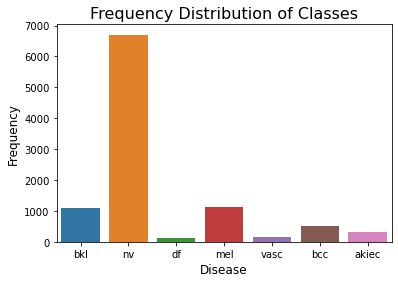

In [7]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

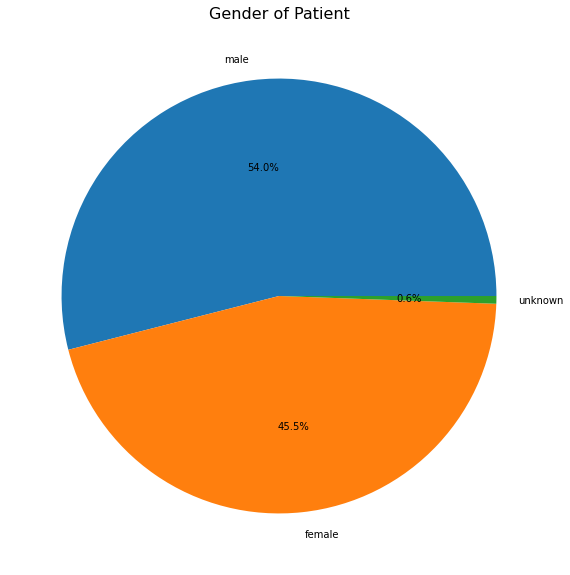

In [8]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

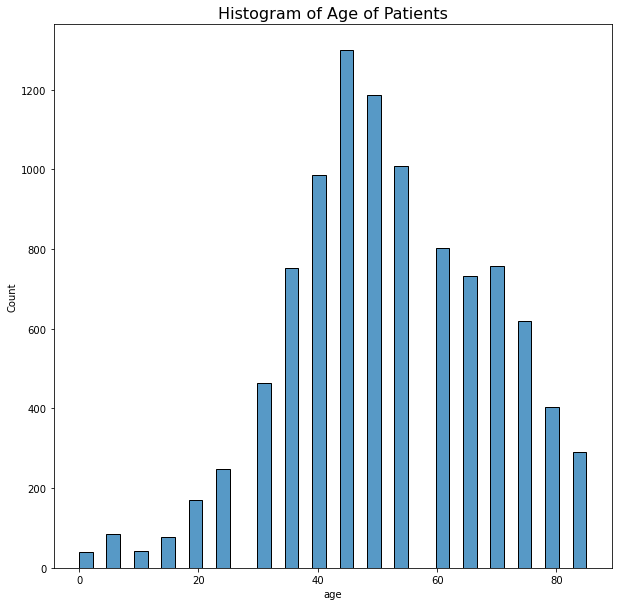

In [9]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

# Location of disease over Gender

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

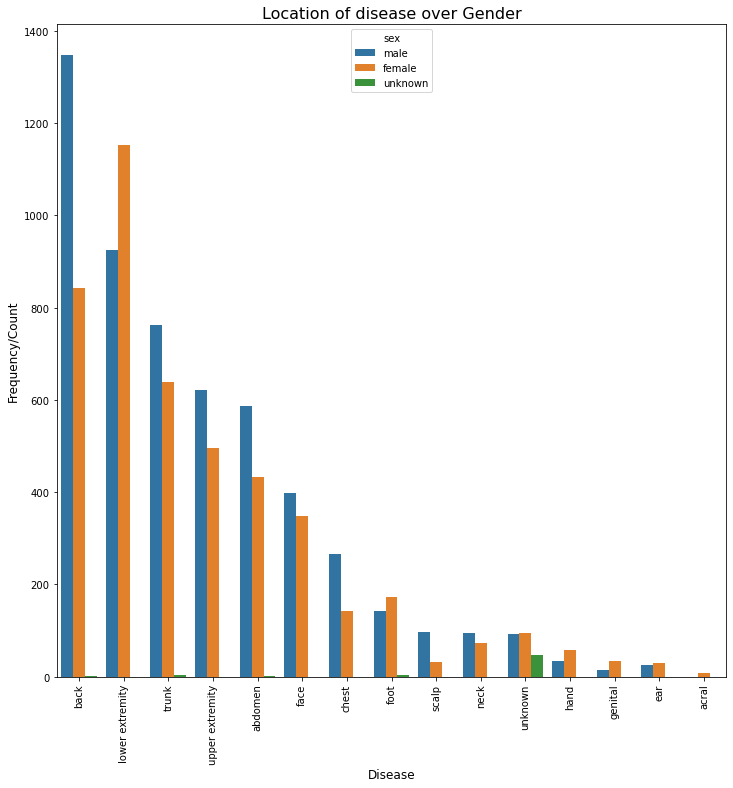

In [10]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Min-max normalization and Split
Beneficial when:
* working with images that have a narrow pixel value range and when the absolute values of pixel intensities are meaningful (e.g., medical images).
* feeding image data to neural networks with activation functions that are sensitive to the range of input values (e.g., sigmoid activation).

In [11]:
#This process ensures that all the input features have the same scale, which can help the model learn more effectively and prevent some features from dominating others.

x = x.astype("float32") / 255.0
x = np.array(x).reshape((-1, height, width, channel))

In [12]:
# Split the data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1)

# Oversampling
**To overcome class imbalace resample the trainset** 

`You can remove the Oversampler by commenting out the cell below`

In [13]:
oversample = RandomOverSampler()
# Reshape X_train to 2 dimensions
X_train_flat = X_train.reshape(-1, x.shape[1] * x.shape[2] * x.shape[3])

# Apply oversampling to the flattened X_train
X_train, Y_train = oversample.fit_resample(X_train_flat, Y_train)
# Reshape the flattened X_train_resampled back to its original shape
X_train = X_train.reshape(-1, x.shape[1], x.shape[2], x.shape[3])


# Model Training

In [14]:
# Custom CNN Architecture

# model = Sequential()
# model.add(Conv2D(16, kernel_size = (3,3), input_shape = input_shape, activation = 'relu', padding = 'same'))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(7, activation='softmax'))
# model.summary()

## Change below cell to suit pretrained Model
`Change the below cell to your assigned pre-trained model`

`Note that each pretrained model might have it's recommended image size`

In [15]:
# Using Pretrained Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D


# Pretrained Model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

9406464/9406464 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                           

In [16]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 25,
                    callbacks=[callback])

Epoch 1/25
239/241 [============================>.] - ETA: 0s - loss: 1.6352 - accuracy: 0.3719
Epoch 1: saving model to best_model.h5
241/241 [==============================] - 19s 60ms/step - loss: 1.6341 - accuracy: 0.3727 - val_loss: 2.8572 - val_accuracy: 0.2004
Epoch 2/25
241/241 [==============================] - ETA: 0s - loss: 1.2779 - accuracy: 0.5274
Epoch 2: saving model to best_model.h5
241/241 [==============================] - 12s 51ms/step - loss: 1.2779 - accuracy: 0.5274 - val_loss: 2.6625 - val_accuracy: 0.2554
Epoch 3/25
241/241 [==============================] - ETA: 0s - loss: 1.0912 - accuracy: 0.5980
Epoch 3: saving model to best_model.h5
241/241 [==============================] - 13s 55ms/step - loss: 1.0912 - accuracy: 0.5980 - val_loss: 2.4802 - val_accuracy: 0.2792
Epoch 4/25
241/241 [==============================] - ETA: 0s - loss: 0.9705 - accuracy: 0.6491
Epoch 4: saving model to best_model.h5
241/241 [==============================] - 13s 56ms/step - lo

# Plot Accuracy and Loss

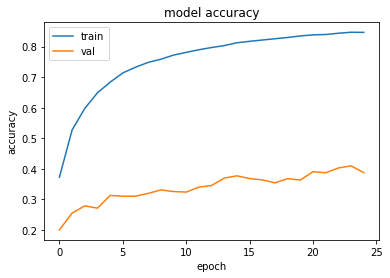

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

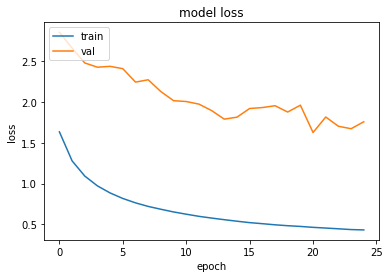

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save Model

In [19]:
import tensorflow as tf

model.save('best_model.h5')
model.save_weights('best_model_weights.h5')

model = tf.keras.models.load_model('best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("best_model1.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\maryp\AppData\Local\Temp\tmpup0kojef\assets


INFO:tensorflow:Assets written to: C:\Users\maryp\AppData\Local\Temp\tmpup0kojef\assets


9206936

# Model Evaluation on Validation Set

In [20]:
import itertools
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 


In [22]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

63/63 - 2s - loss: 1.2838 - accuracy: 0.6640 - 2s/epoch - 26ms/step


63/63 [==============================] - 2s 19ms/step


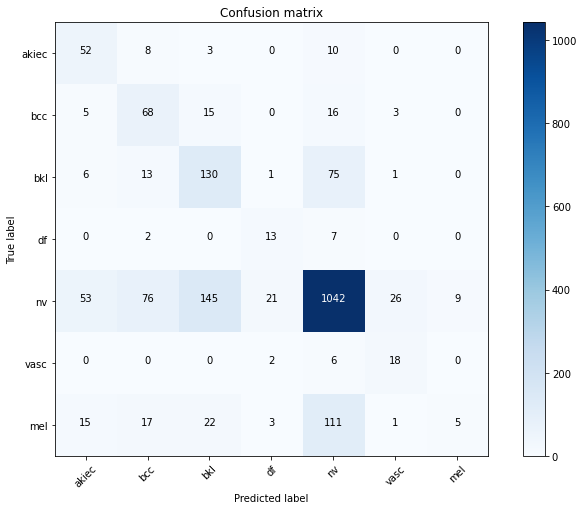

In [23]:
classes = {k:v[0] for k,v in classes.items()}
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
confusion_mtx = confusion_matrix(Y_test, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values())

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_pred = np.argmax(model.predict(X_test),axis=1)
print(classification_report(np.float32(Y_test), Y_pred.round()))
print('Classification Report')

63/63 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         0.0       0.40      0.71      0.51        73
         1.0       0.37      0.64      0.47       107
         2.0       0.41      0.58      0.48       226
         3.0       0.33      0.59      0.42        22
         4.0       0.82      0.76      0.79      1372
         5.0       0.37      0.69      0.48        26
         6.0       0.36      0.03      0.05       174

    accuracy                           0.66      2000
   macro avg       0.44      0.57      0.46      2000
weighted avg       0.68      0.66      0.66      2000

Classification Report


# Model Evaluation on Test Set

In [26]:
Y_testset = testset['label']
X_testset = testset.drop(columns = ['label'])

X_testset= np.array(X_testset).reshape(reshape)
print('Shape of X_testset :',X_testset.shape)

# scale the data
X_testset = X_testset.astype("float32") / 255.0

Shape of X_testset : (1511, 32, 32, 3)


In [27]:
loss, acc = model.evaluate(X_testset, Y_testset, verbose=2)

48/48 - 1s - loss: 3.0377 - accuracy: 0.4811 - 714ms/epoch - 15ms/step


48/48 [==============================] - 1s 17ms/step


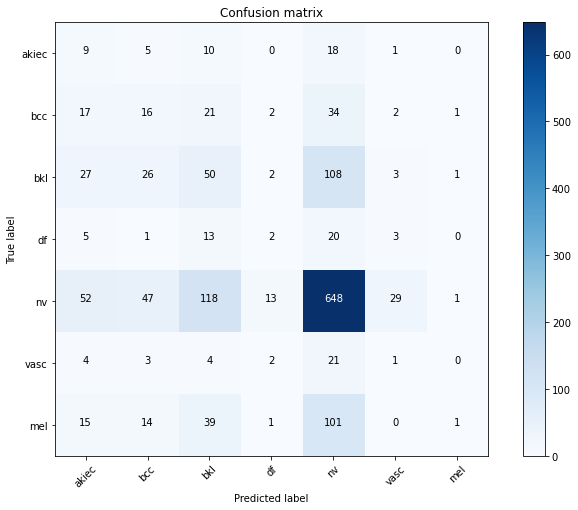

In [28]:
Y_testset_pred = model.predict(X_testset)
Y_testset_pred_classes = np.argmax(Y_testset_pred,axis = 1) 
confusion_mtx = confusion_matrix(Y_testset, Y_testset_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes.values())

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
Y_testset_pred = np.argmax(model.predict(X_testset),axis=1)
print(classification_report(np.float32(Y_testset), Y_testset_pred.round()))
print('Classification Report')

48/48 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

         0.0       0.07      0.21      0.10        43
         1.0       0.14      0.17      0.16        93
         2.0       0.20      0.23      0.21       217
         3.0       0.09      0.05      0.06        44
         4.0       0.68      0.71      0.70       908
         5.0       0.03      0.03      0.03        35
         6.0       0.25      0.01      0.01       171

    accuracy                           0.48      1511
   macro avg       0.21      0.20      0.18      1511
weighted avg       0.48      0.48      0.47      1511

Classification Report
